In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 50)

<class 'ModuleNotFoundError'>: No module named 'plotly'

In [284]:
# assumptions: interest rate, term, installment are only known after approval decision
# risk score is given before (credit score)

## 1. Import Dataset / Clean

In [285]:
df_loans = pd.read_csv('cc_loan_reduced.csv')
df_og = df_loans.copy(deep = True)

print(df_loans['record_id'].nunique())
print(df_loans.shape)
df_loans.head(8)

44543
(44543, 72)


,record_id,issue_d,loan_amnt,term,int_rate,installment,score,loan_status,total_pymnt,last_pymnt_d,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,0,Aug-2015,15000,36 months,14.65,517.42,0.219093,Charged Off,13484.010000,Nov-2017,MARKETING OPERATIONS MANAGER,2 years,RENT,57000.0,Source Verified,debt_consolidation,Debt consolidation,925xx,CA,16.78,0.0,Mar-2004,0.0,NaN,94.0,11.0,1.0,5482,38.6,21.0,0.0,NaN,0.0,0.0,36894.0,14200.0,4.0,3354.0,0.0,104.3,0.0,137.0,137.0,1.0,1.0,1.0,86.0,NaN,13.0,NaN,0.0,1.0,7.0,1.0,5.0,4.0,10.0,16.0,7.0,11.0,0.0,0.0,0.0,2.0,100.0,100.0,1.0,0.0,50898.0,36894.0,2300.0,36698.0
1,1,Oct-2015,10000,36 months,5.32,301.15,0.067309,Fully Paid,10833.924836,Oct-2018,English Department Chairman,10+ years,MORTGAGE,130000.0,Source Verified,debt_consolidation,Debt consolidation,212xx,MD,19.42,0.0,Nov-1989,0.0,NaN,NaN,19.0,0.0,16916,39.2,37.0,0.0,NaN,0.0,0.0,246163.0,43100.0,4.0,12956.0,16425.0,25.0,0.0,159.0,311.0,30.0,4.0,5.0,30.0,NaN,NaN,NaN,0.0,6.0,10.0,9.0,10.0,14.0,14.0,18.0,10.0,19.0,0.0,0.0,0.0,1.0,100.0,11.1,0.0,0.0,317388.0,51181.0,21900.0,67393.0
2,2,Jan-2014,24000,36 months,7.62,747.88,0.015098,Fully Paid,25184.850003,Oct-2014,Director,10+ years,MORTGAGE,185000.0,Verified,debt_consolidation,Debt consolidation,115xx,NY,15.31,0.0,Aug-2002,1.0,NaN,NaN,12.0,0.0,19135,41.1,18.0,0.0,NaN,0.0,0.0,401387.0,46600.0,6.0,36490.0,23637.0,44.5,0.0,50.0,137.0,3.0,3.0,2.0,3.0,NaN,6.0,NaN,0.0,5.0,6.0,6.0,6.0,6.0,9.0,10.0,6.0,12.0,0.0,0.0,0.0,4.0,100.0,16.7,0.0,0.0,450015.0,86778.0,42600.0,75415.0
3,3,Sep-2015,9600,36 months,13.99,328.06,0.167956,Fully Paid,11824.009057,Oct-2018,instructor-driver,6 years,MORTGAGE,47500.0,Source Verified,debt_consolidation,Debt consolidation,937xx,CA,27.70,0.0,Sep-1990,1.0,66.0,NaN,7.0,0.0,12672,88.6,21.0,0.0,NaN,0.0,0.0,200080.0,14300.0,6.0,28583.0,17.0,99.8,0.0,123.0,300.0,4.0,3.0,3.0,10.0,NaN,4.0,NaN,1.0,1.0,3.0,1.0,3.0,7.0,3.0,11.0,3.0,7.0,0.0,0.0,0.0,3.0,85.7,100.0,0.0,0.0,225480.0,30009.0,10000.0,26780.0
4,4,Sep-2015,8000,36 months,12.29,266.83,0.233873,Fully Paid,9591.786147,Sep-2018,biller,10+ years,RENT,60000.0,Source Verified,other,Other,328xx,FL,11.28,0.0,Sep-1991,1.0,NaN,NaN,10.0,0.0,2789,32.1,33.0,0.0,NaN,0.0,0.0,83282.0,8700.0,6.0,8328.0,5775.0,19.8,0.0,149.0,287.0,2.0,2.0,5.0,2.0,NaN,6.0,NaN,0.0,4.0,5.0,5.0,14.0,7.0,6.0,21.0,5.0,10.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,117547.0,14484.0,7200.0,18847.0
5,5,Dec-2014,13850,36 months,8.19,435.23,0.040000,Fully Paid,15528.153861,Feb-2017,Contract Administrator,< 1 year,MORTGAGE,55000.0,Source Verified,credit_card,Credit card refinancing,171xx,PA,27.74,0.0,Jan-2002,0.0,NaN,NaN,12.0,0.0,13333,31.6,52.0,0.0,NaN,0.0,0.0,37460.0,42200.0,8.0,3405.0,18202.0,42.2,0.0,124.0,155.0,3.0,3.0,3.0,3.0,NaN,4.0,NaN,0.0,3.0,4.0,4.0,14.0,15.0,10.0,33.0,4.0,12.0,0.0,0.0,0.0,4.0,100.0,25.0,0.0,0.0,75270.0,37460.0,31500.0,33070.0
6,6,May-2015,20425,36 months,10.99,668.60,0.076343,Fully Paid,23777.799141,Jul-2017,Special education teacher,3 years,MORTGAGE,73000.0,Verified,debt_consolidation,Debt consolidation,010xx,MA,32.29,0.0,Aug-2001,1.0,NaN,NaN,1

In [286]:
# Check which columns are not numeric
# Expected: 
## issue_d (date)
## loan_status (string/cat): ['Charged Off', 'Fully Paid']
## last_pymnt_d (date)
## emp_title (string): job title
## emp_length (string/cat): length of employment
## home_ownership (string/cat): ['RENT', 'MORTGAGE', 'OWN']
## verification_status: whether income was verified
## purpose (string/cat)
## title (string): title provider by borrower
## zip_code (string/cat): only first three numbers, general area
## addr_state (string/cat): state
## earliest_cr_line (date): earliest credit line opened

[col for col in df_loans.columns if not pd.api.types.is_numeric_dtype(df_loans[col])]

['issue_d',
 'term',
 'loan_status',
 'last_pymnt_d',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line']

In [287]:
# Fix zip_code (there are some that have few rows)

zip_counts = df_loans['zip_code'].value_counts()

threshold = 100 
rare_zips = zip_counts[zip_counts < threshold].index
df_loans['zip_code'] = df_loans['zip_code'].apply(
    lambda x: 'Other' if x in rare_zips else x
)

In [288]:
# Correct type for columns, identify which ones have less predictive power or shouldn/t be used
## term: all the loans have the same term: 36 months

cols_ignore = ['record_id', 'term', 'issue_d', 'last_pymnt_d', 'loan_status', 'emp_title', 'title', 
               'avg_cur_bal', 'total_pymnt', 'installment', 'int_rate']


In [289]:
# Create binary target
df_loans['default'] = (df_loans['loan_status'] == 'Charged Off').astype(int)
cols_ignore += ['default']

In [290]:
# Check missingness

(df_loans[[col for col in df_loans.columns if col not in cols_ignore]].isnull().sum() / 
 len(df_loans) * 100).sort_values(ascending = False).head(20)

mths_since_last_record            81.027322
mths_since_recent_bc_dlq          73.353838
mths_since_last_major_derog       69.728128
mths_since_recent_revol_delinq    63.222055
mths_since_last_delinq            48.081629
mths_since_recent_inq             10.140763
emp_length                         6.328716
num_tl_120dpd_2m                   4.606784
mo_sin_old_il_acct                 3.558359
bc_util                            1.088836
percent_bc_gt_75                   1.086590
bc_open_to_buy                     1.023730
mths_since_recent_bc               0.972094
revol_util                         0.038165
num_tl_30dpd                       0.000000
num_bc_sats                        0.000000
total_bc_limit                     0.000000
total_bal_ex_mort                  0.000000
tot_hi_cred_lim                    0.000000
num_accts_ever_120_pd              0.000000
dtype: float64

## 2. Feature Engineering

In [291]:
# Let's deal with the missing variables

df_loans['has_public_record'] = df_loans['mths_since_last_record'].notna().astype(int)
cols_ignore += ['mths_since_last_record']
df_loans['has_public_record'].value_counts()

has_public_record
0    36092
1     8451
Name: count, dtype: int64

In [292]:
df_loans['has_bankcard_delinq'] = df_loans['mths_since_recent_bc_dlq'].notna().astype(int)
cols_ignore += ['mths_since_recent_bc_dlq']
df_loans['has_bankcard_delinq'].value_counts()

has_bankcard_delinq
0    32674
1    11869
Name: count, dtype: int64

In [293]:
df_loans['has_major_derog'] = df_loans['mths_since_last_major_derog'].notna().astype(int)
cols_ignore += ['mths_since_last_major_derog']
df_loans['has_major_derog'].value_counts()

has_major_derog
0    31059
1    13484
Name: count, dtype: int64

In [294]:
df_loans['has_revol_delinq'] = df_loans['mths_since_recent_revol_delinq'].notna().astype(int)
cols_ignore += ['mths_since_recent_revol_delinq']
df_loans['has_revol_delinq'].value_counts()

has_revol_delinq
0    28161
1    16382
Name: count, dtype: int64

In [295]:
df_loans['has_any_delinq'] = df_loans['mths_since_last_delinq'].notna().astype(int)
cols_ignore += ['mths_since_last_delinq']
df_loans['has_any_delinq'].value_counts()

has_any_delinq
1    23126
0    21417
Name: count, dtype: int64

In [296]:
df_loans['mths_since_recent_inq'] = df_loans['mths_since_recent_inq'].fillna(np.nanmedian(df_loans['mths_since_recent_inq']))
df_loans['mths_since_recent_inq'].value_counts()

mths_since_recent_inq
5.0     7210
1.0     4597
2.0     3646
0.0     3532
3.0     3298
4.0     3051
6.0     2298
7.0     2186
8.0     1913
9.0     1624
10.0    1478
11.0    1370
12.0    1131
13.0    1042
14.0     958
15.0     804
16.0     773
17.0     661
18.0     558
19.0     505
20.0     464
21.0     437
22.0     423
23.0     384
24.0     198
25.0       2
Name: count, dtype: int64

In [297]:
df_loans['emp_length'] = df_loans['emp_length'].fillna(df_loans['emp_length'].mode()[0])
df_loans['emp_length'] = df_loans['emp_length'].str.replace(' years', '').str.replace(' year', '')
df_loans['emp_length'].value_counts(dropna = False)

emp_length
10+    16907
2       4009
< 1     3719
3       3532
1       2901
4       2691
5       2655
8       2201
7       2158
6       2000
9       1770
Name: count, dtype: int64

In [298]:
df_loans['num_tl_120dpd_2m'] = df_loans['num_tl_120dpd_2m'].fillna(np.nanmedian(df_loans['num_tl_120dpd_2m']))
df_loans['num_tl_120dpd_2m'].value_counts()

num_tl_120dpd_2m
0.0    44497
1.0       45
3.0        1
Name: count, dtype: int64

In [299]:
df_loans['mo_sin_old_il_acct'] = df_loans['mo_sin_old_il_acct'].fillna(np.nanmedian(df_loans['mo_sin_old_il_acct']))
df_loans['mo_sin_old_il_acct'].value_counts()

mo_sin_old_il_acct
128.0    2105
123.0     542
127.0     533
126.0     531
130.0     524
         ... 
430.0       1
379.0       1
351.0       1
376.0       1
394.0       1
Name: count, Length: 382, dtype: int64

In [300]:
df_loans['bc_util'] = df_loans['bc_util'].fillna(np.nanmedian(df_loans['bc_util']))
df_loans['bc_util'].value_counts()

bc_util
65.2     527
0.0      461
98.0     131
95.0     129
96.0     128
        ... 
104.2      1
107.5      1
115.6      1
114.3      1
148.1      1
Name: count, Length: 1118, dtype: int64

In [301]:
df_loans['percent_bc_gt_75'] = df_loans['percent_bc_gt_75'].fillna(np.nanmedian(df_loans['percent_bc_gt_75']))
df_loans['percent_bc_gt_75'].value_counts()

percent_bc_gt_75
0.00      9705
100.00    8664
50.00     5711
33.30     3162
66.70     3067
          ... 
10.30        1
0.14         1
52.60        1
22.70        1
93.30        1
Name: count, Length: 119, dtype: int64

In [302]:
df_loans['bc_open_to_buy'] = df_loans['bc_open_to_buy'].fillna(np.nanmedian(df_loans['bc_open_to_buy']))
df_loans['bc_open_to_buy'].value_counts()

bc_open_to_buy
0.0        878
3991.0     460
2000.0      54
2500.0      44
1000.0      44
          ... 
12153.0      1
5749.0       1
6437.0       1
17839.0      1
23686.0      1
Name: count, Length: 18322, dtype: int64

In [303]:
df_loans['mths_since_recent_bc'] = df_loans['mths_since_recent_bc'].fillna(np.nanmedian(df_loans['mths_since_recent_bc']))
df_loans['mths_since_recent_bc'].value_counts()

mths_since_recent_bc
3.0      2224
2.0      2164
4.0      2155
5.0      1908
6.0      1827
         ... 
228.0       1
221.0       1
207.0       1
291.0       1
233.0       1
Name: count, Length: 293, dtype: int64

In [304]:
df_loans['revol_util'] = df_loans['revol_util'].fillna(np.nanmedian(df_loans['revol_util']))
df_loans['revol_util'].value_counts()

revol_util
0.0      166
49.0     115
45.0     113
50.0     109
41.0     108
        ... 
113.4      1
105.3      1
102.4      1
105.9      1
103.9      1
Name: count, Length: 1062, dtype: int64

In [305]:
# Check missingness

(df_loans[[col for col in df_loans.columns if col not in cols_ignore]].isnull().sum() / 
 len(df_loans) * 100).sort_values(ascending = False).head(20)

loan_amnt                0.0
mort_acc                 0.0
mths_since_recent_inq    0.0
num_accts_ever_120_pd    0.0
num_actv_bc_tl           0.0
num_actv_rev_tl          0.0
num_bc_sats              0.0
num_bc_tl                0.0
num_il_tl                0.0
num_op_rev_tl            0.0
num_rev_accts            0.0
num_rev_tl_bal_gt_0      0.0
num_sats                 0.0
num_tl_120dpd_2m         0.0
num_tl_30dpd             0.0
num_tl_90g_dpd_24m       0.0
num_tl_op_past_12m       0.0
pct_tl_nvr_dlq           0.0
percent_bc_gt_75         0.0
pub_rec_bankruptcies     0.0
dtype: float64

Overall default rate: 14.31%
Number of defaults: 6375


Text(0.5, 1.0, 'Default Rate by Issue Date')

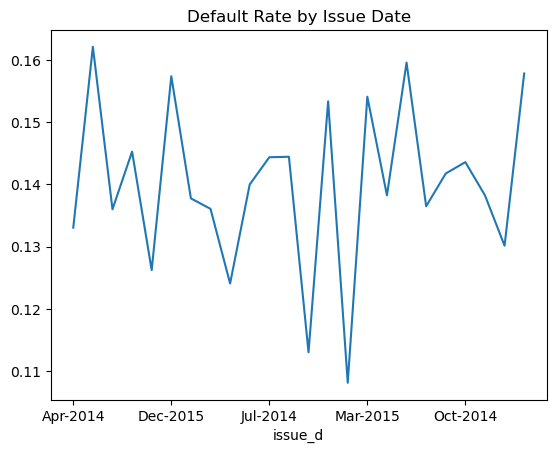

In [306]:
# Default rate
print(f"Overall default rate: {df_loans['default'].mean():.2%}")
print(f"Number of defaults: {df_loans[df_loans['default'] == 1].shape[0]}")

# Default rate over time
df_loans.groupby('issue_d')['default'].mean().plot()
plt.title('Default Rate by Issue Date')

<Axes: >

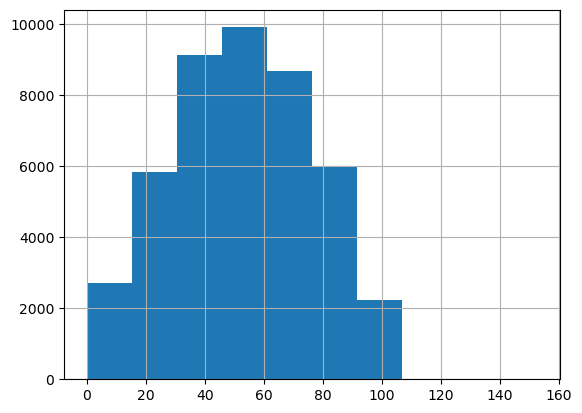

In [307]:
df_loans['revol_util'].hist()

In [308]:
## Other features

# Income bins (log)
df_loans['income_bin'] = pd.cut(df_loans['annual_inc'], 
                                 bins=[0, 30000, 50000, 60000, 75000, 100000, np.inf],
                                 labels=['<30k', '30-50k', '50-60k', '60-75k', '75-100k', '100k+'])
cols_ignore += ['annual_inc']

# DTI bins 
df_loans['dti_bin'] = pd.cut(df_loans['dti'],
                              bins=[0, 5, 10, 15, 20, 25, 30, 35,np.inf],
                              labels=['<5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35+'])
cols_ignore += ['dti']

# Loan amount bins
df_loans['loan_amnt_bin'] = pd.qcut(df_loans['loan_amnt'], 
                                     q=5, 
                                     labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
cols_ignore += ['loan_amnt']

# Revolving utilization bins 
df_loans['revol_util_bin'] = pd.cut(df_loans['revol_util'],
                                     bins=[0, 30, 50, 60, 70, 80, 90, np.inf],
                                     labels=['<30%', '30-50%', '50-60%', '60-70%', '70-80%', '80-90%', '>90%'])
cols_ignore += ['revol_util']

In [309]:
df_loans['revol_util_bin'].value_counts()

revol_util_bin
30-50%    12152
<30%       8118
50-60%     6511
60-70%     6050
70-80%     5039
80-90%     3778
>90%       2729
Name: count, dtype: int64

<Axes: >

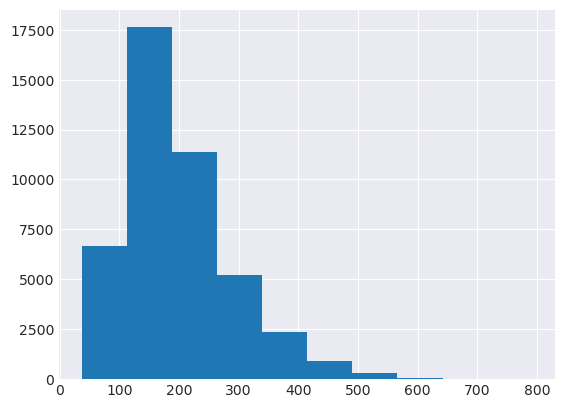

In [342]:
# Credit History
df_loans['issue_d'] = pd.to_datetime(df_loans['issue_d'], format = '%b-%Y')
df_loans['earliest_cr_line'] = pd.to_datetime(df_loans['earliest_cr_line'], format = '%b-%Y')
    
df_loans['credit_history_months'] = (df_loans['issue_d'] - df_loans['earliest_cr_line']).dt.days / 30.44
cols_ignore += ['earliest_cr_line']
df_loans['credit_history_months'].hist()

In [311]:
'''
# Income to loan ratio
df_loans['income_to_loan'] = df_loans['annual_inc'] / df_loans['loan_amnt']
'''

# Available credit
df_loans['available_credit'] = df_loans['bc_open_to_buy'] + (df_loans['total_bc_limit'] - df_loans['total_bal_ex_mort'])

# Credit utilization overall
df_loans['total_util'] = df_loans['total_bal_ex_mort'] / df_loans['tot_hi_cred_lim']

# Accounts per year of credit history
df_loans['accts_per_year'] = df_loans['total_acc'] / (df_loans['credit_history_months'] / 12)

# Delinquency rate 
df_loans['delinq_rate'] = df_loans['delinq_2yrs'] / df_loans['total_acc'].replace(0, 1)

<Axes: >

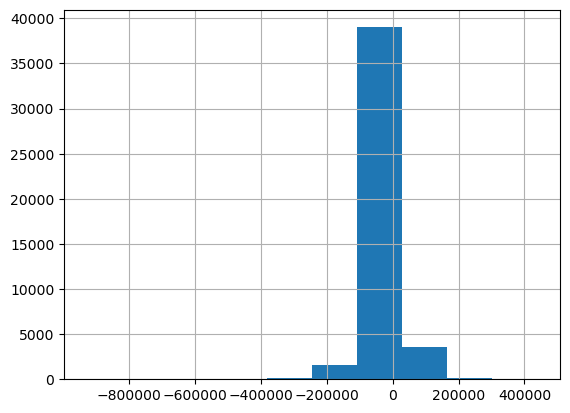

In [312]:
df_loans['available_credit'].hist()

In [313]:
# ENCODING: no, for now
'''
# Categorical Variables

cat_cols = ['addr_state', 'purpose', 'home_ownership', 'verification_status', 
            'emp_length', 'zip_code']

# Encoding
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    df_loans[col + '_encoded'] = le.fit_transform(df_loans[col].astype(str))
    cols_ignore += [col]
'''

## 3. Exploratory

In [317]:
df_loans[df_loans['default'] == 1]['purpose'].value_counts()

purpose
debt_consolidation    3853
credit_card           1298
other                  410
home_improvement       314
major_purchase         112
medical                 97
small_business          80
moving                  72
vacation                56
car                     47
house                   26
renewable_energy        10
Name: count, dtype: int64

In [318]:
# Cats
cat_cols = ['purpose', 'home_ownership', 'addr_state', 'emp_length']

for col in cat_cols:
    print(f"\n{col}:")
    print(df_loans.groupby(col)['default'].agg(['mean', 'count']).sort_values('mean', ascending = False).head(10))


purpose:
                        mean  count
purpose                            
renewable_energy    0.263158     38
moving              0.219512    328
small_business      0.187793    426
house               0.181818    143
medical             0.177982    545
vacation            0.174455    321
other               0.171836   2386
debt_consolidation  0.150832  25545
major_purchase      0.135103    829
home_improvement    0.120862   2598

home_ownership:
                    mean  count
home_ownership                 
RENT            0.172922  19211
OWN             0.155904   4785
MORTGAGE        0.112279  20547

addr_state:
                mean  count
addr_state                 
MS          0.195219    251
NE          0.185714     70
ME          0.178571     28
AL          0.176909    537
MD          0.171548    956
RI          0.164948    194
NM          0.163569    269
NV          0.161481    675
FL          0.161473   3177
OK          0.161376    378

emp_length:
                mea

In [322]:
bin_cols = ['income_bin', 'dti_bin', 'loan_amnt_bin', 'revol_util_bin']
all_cols = [col for col in df_loans.columns if (col not in cols_ignore) and (col not in cat_cols) and (col not in bin_cols)]

df_loans.groupby('default')[all_cols].median()

,score,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,has_public_record,has_bankcard_delinq,has_major_derog,has_revol_delinq,has_any_delinq,credit_history_months,available_credit,total_util,accts_per_year,delinq_rate,addr_state_encoded,purpose_encoded,home_ownership_encoded,verification_status_encoded,emp_length_encoded,zip_code_encoded
default,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.152807,0.0,0.0,10.0,0.0,10693.0,23.0,0.0,0.0,0.0,69538.5,22600.0,4.0,4150.5,65.0,0.0,128.0,168.0,8.0,6.0,1.0,14.0,5.0,0.0,3.0,5.0,4.0,7.0,6.0,7.0,13.0,5.0,10.0,0.0,0.0,0.0,2.0,97.3,50.0,0.0,0.0,99854.0,35201.5,14100.0,29557.0,0.0,0.0,0.0,0.0,1.0,180.946124,-12005.0,0.417056,1.521208,0.0,21.0,2.0,1.0,1.0,2.0,116.0
1,0.195348,0.0,1.0,11.0,0.0,9570.0,22.0,0.0,0.0,0.0,47366.0,19000.0,5.0,2913.0,69.0,0.0,126.0,152.0,7.0,5.0,0.0,12.0,5.0,0.0,3.0,5.0,4.0,7.0,6.0,8.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,97.1,50.0,0.0,0.0,69105.0,33191.0,10900.0,28150.0,0.0,0.0,0.0,0.0,1.0,168.988173,-14781.0,0.556801,1.595412,0.0,21.0,2.0,2.0,1.0,2.0,113.0


In [324]:
# Correlations

numeric_cols = df_loans.select_dtypes(include=[np.number]).columns.difference(cols_ignore)
correlations = df_loans[numeric_cols].corrwith(df_loans['default']).sort_values(ascending = False)
print(correlations.head(20))

score                          0.132067
acc_open_past_24mths           0.100028
total_util                     0.098765
num_tl_op_past_12m             0.092650
home_ownership_encoded         0.081890
inq_last_6mths                 0.070774
verification_status_encoded    0.062258
percent_bc_gt_75               0.052131
num_actv_rev_tl                0.051837
num_rev_tl_bal_gt_0            0.051180
bc_util                        0.050712
purpose_encoded                0.036059
accts_per_year                 0.029230
has_public_record              0.029021
pub_rec_bankruptcies           0.026575
has_major_derog                0.024582
num_actv_bc_tl                 0.023417
num_op_rev_tl                  0.022016
delinq_rate                    0.019859
num_accts_ever_120_pd          0.017997
dtype: float64


In [327]:
# Correlation matrix
corr_matrix = df_loans[numeric_cols].corr()

# Find highly correlated pairs (>0.8 or 0.9)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:  # threshold
            high_corr.append((corr_matrix.columns[i], 
                            corr_matrix.columns[j], 
                            corr_matrix.iloc[i, j]))

print("Highly correlated pairs (>0.8):")
for col1, col2, corr_val in high_corr:
    print(f"{col1} <-> {col2}: {corr_val:.3f}")

Highly correlated pairs (>0.8):
bc_open_to_buy <-> total_bc_limit: 0.841
bc_util <-> percent_bc_gt_75: 0.832
credit_history_months <-> mo_sin_old_rev_tl_op: 0.922
delinq_2yrs <-> delinq_rate: 0.886
num_actv_bc_tl <-> num_bc_sats: 0.834
num_actv_rev_tl <-> num_op_rev_tl: 0.804
num_actv_rev_tl <-> num_rev_tl_bal_gt_0: 0.983
num_bc_tl <-> num_rev_accts: 0.841
num_op_rev_tl <-> num_rev_tl_bal_gt_0: 0.809
num_op_rev_tl <-> num_sats: 0.819
num_op_rev_tl <-> open_acc: 0.820
num_sats <-> open_acc: 0.998
revol_bal <-> total_rev_hi_lim: 0.851
tot_cur_bal <-> tot_hi_cred_lim: 0.984
total_bal_ex_mort <-> total_il_high_credit_limit: 0.869


In [328]:
# Definitions are slightly worse, dropping when corr is higher than 0.9
cols_ignore += ['mo_sin_old_rev_tl_op', 'num_actv_rev_tl', 'num_sats', 'tot_hi_cred_lim']

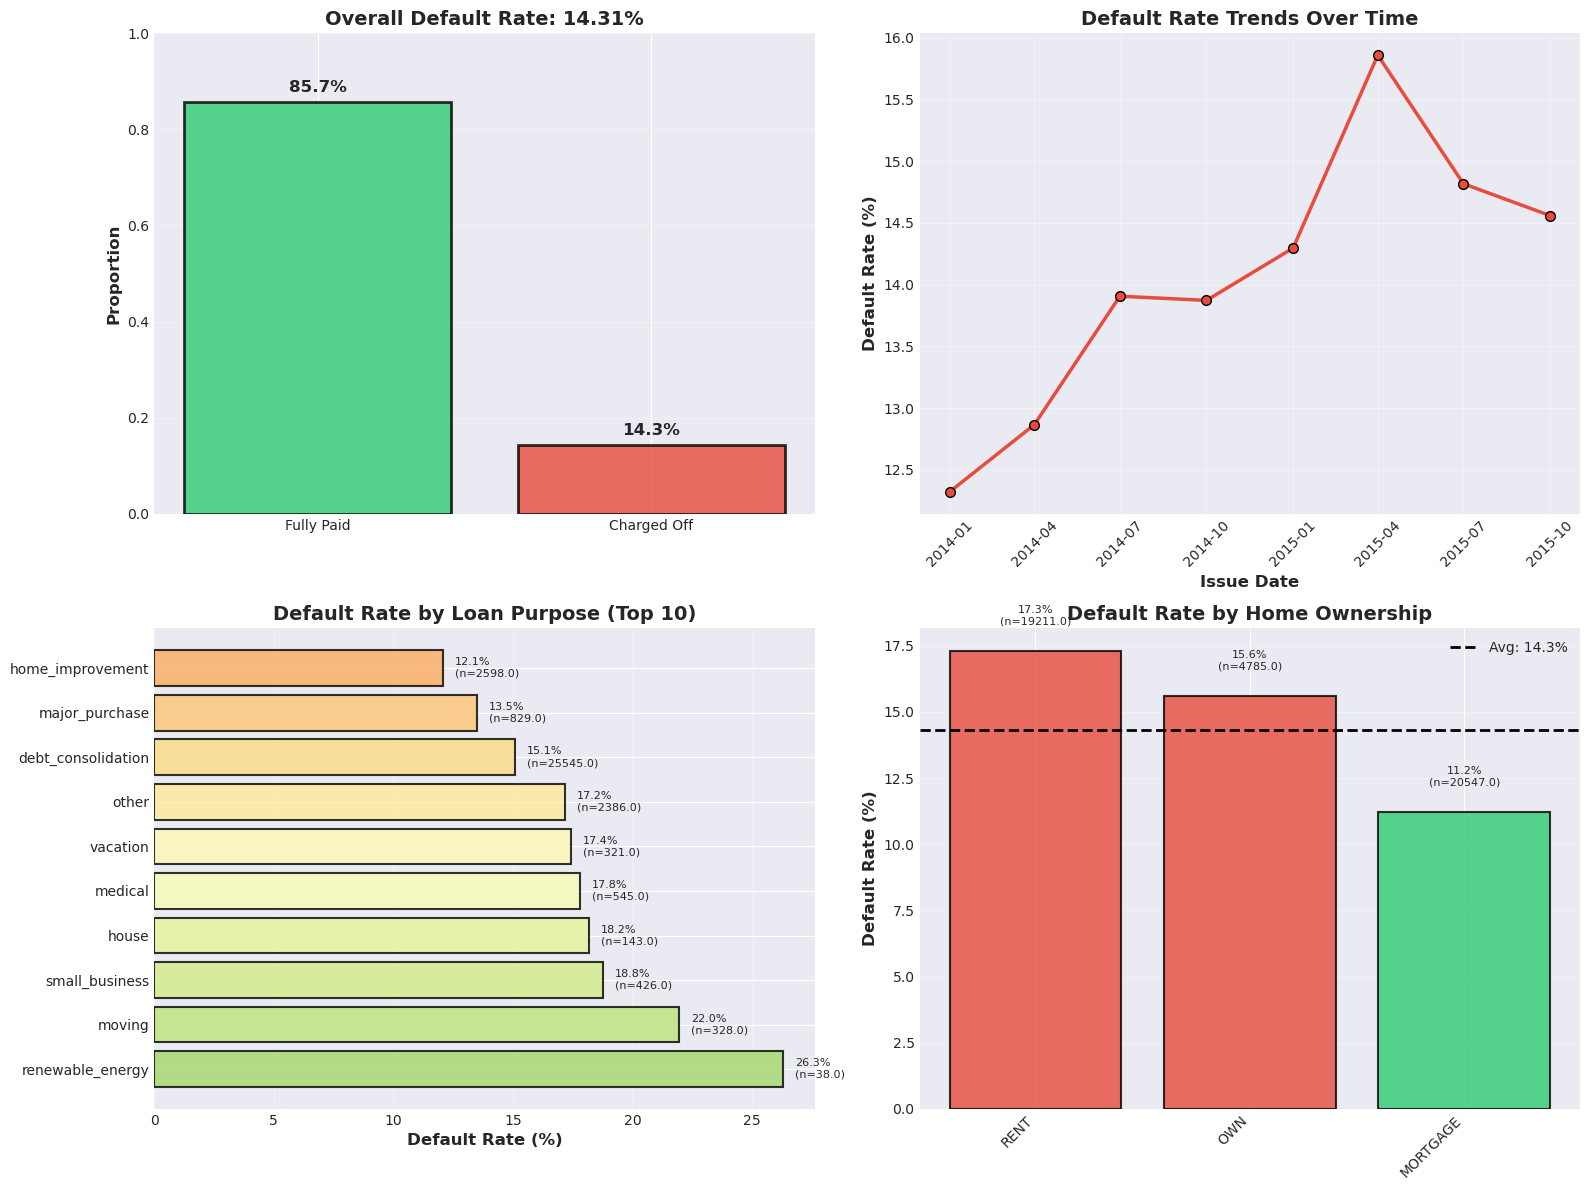

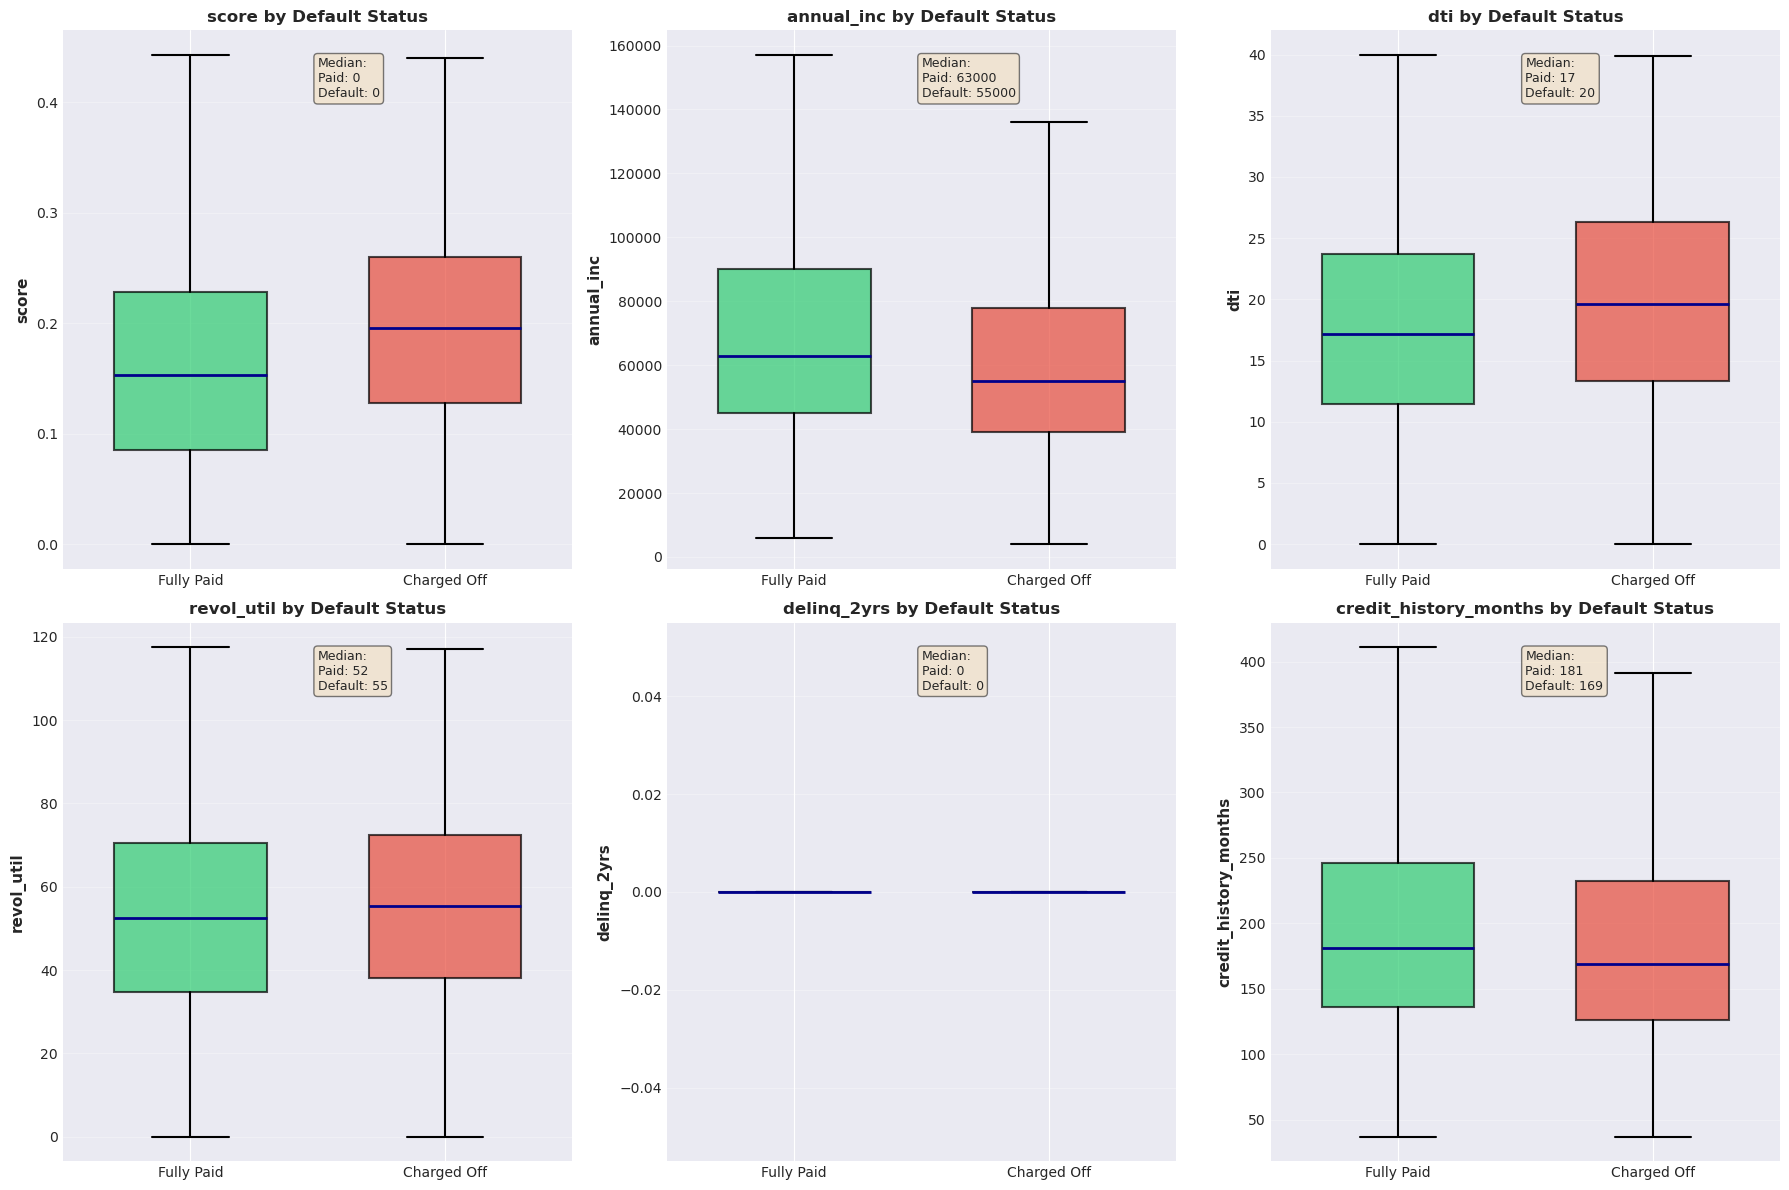

<ipython-input-343-0b375f99632b>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df_loans.groupby(col)['default'].agg(['mean', 'count']).reset_index()
<ipython-input-343-0b375f99632b>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df_loans.groupby(col)['default'].agg(['mean', 'count']).reset_index()
<ipython-input-343-0b375f99632b>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stat

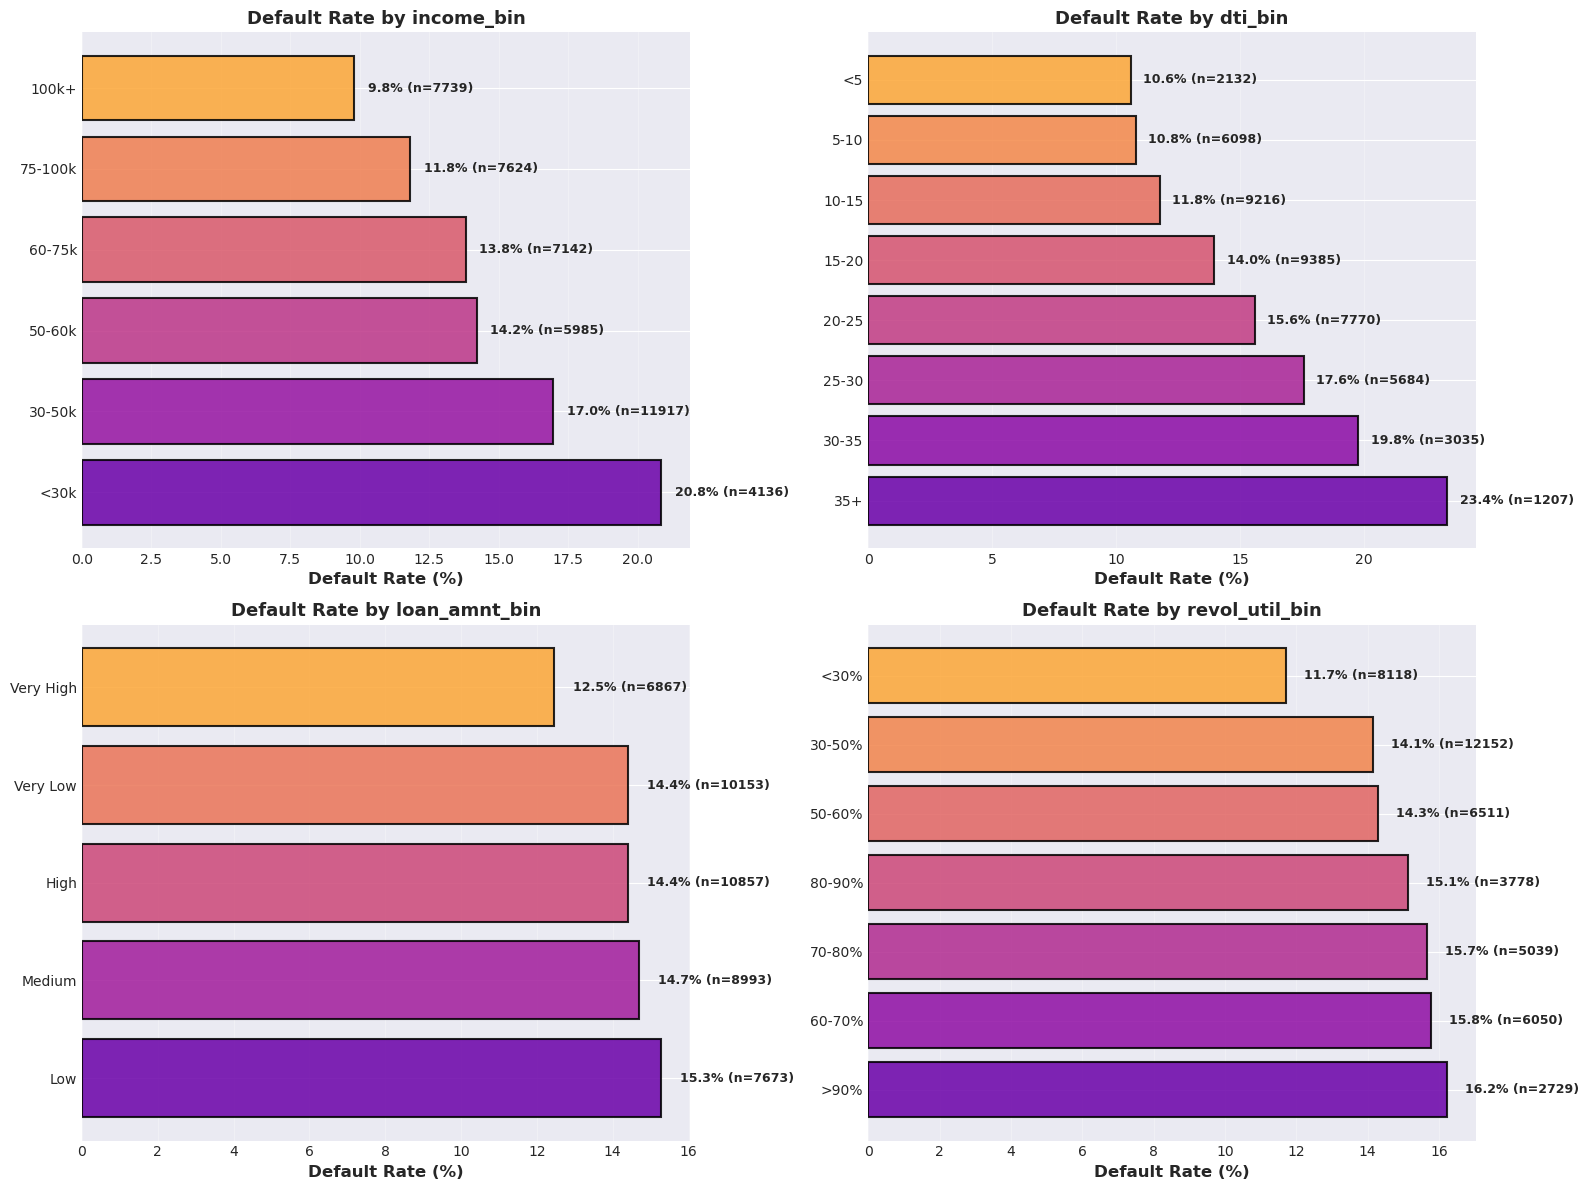

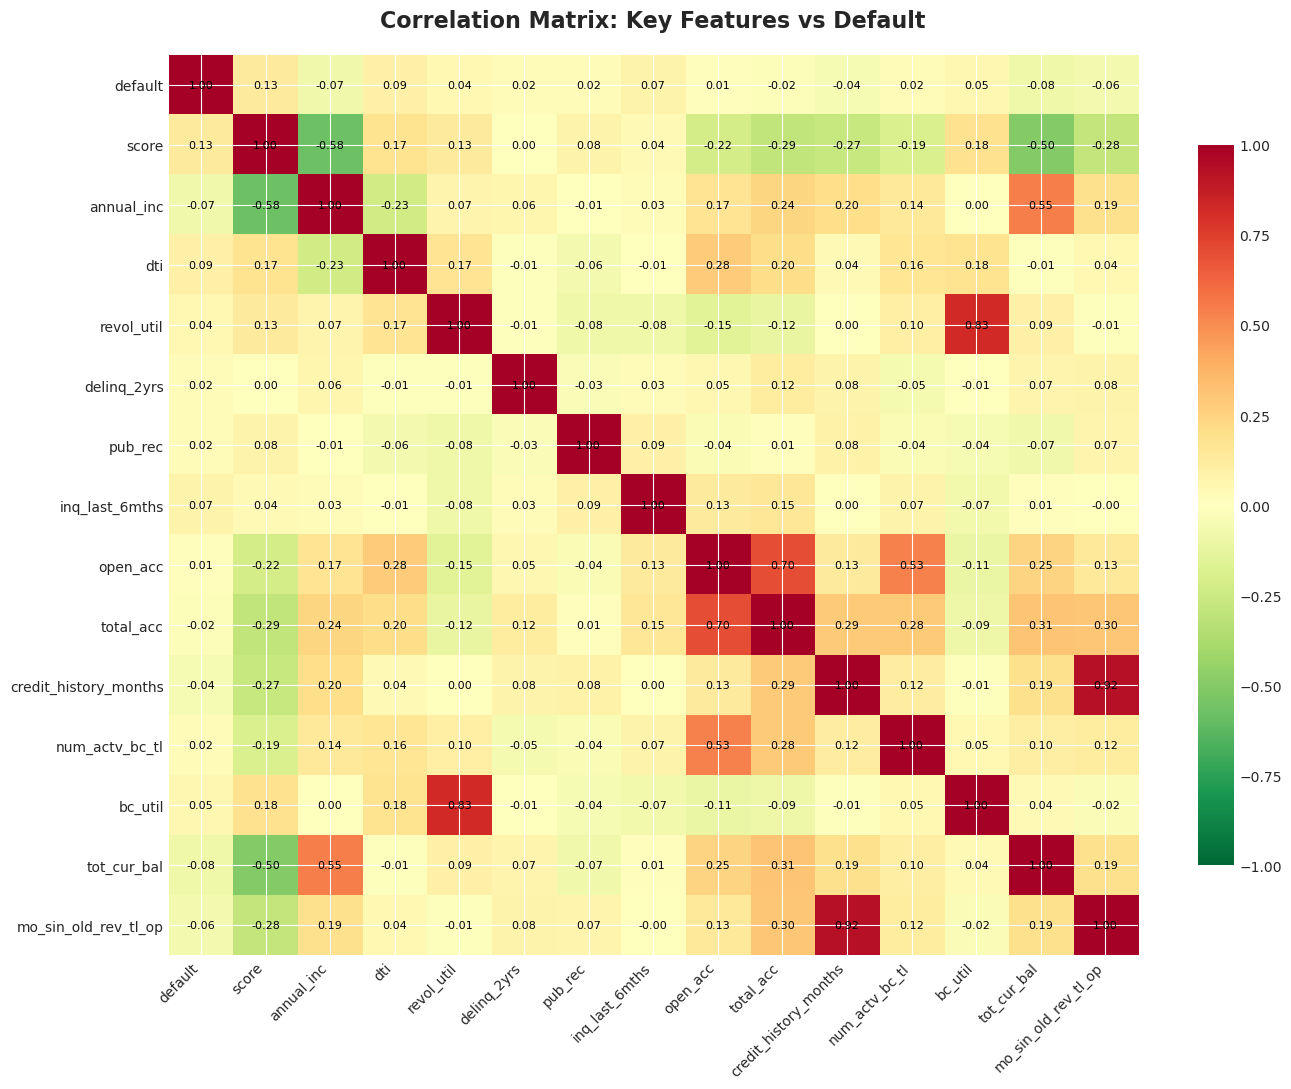

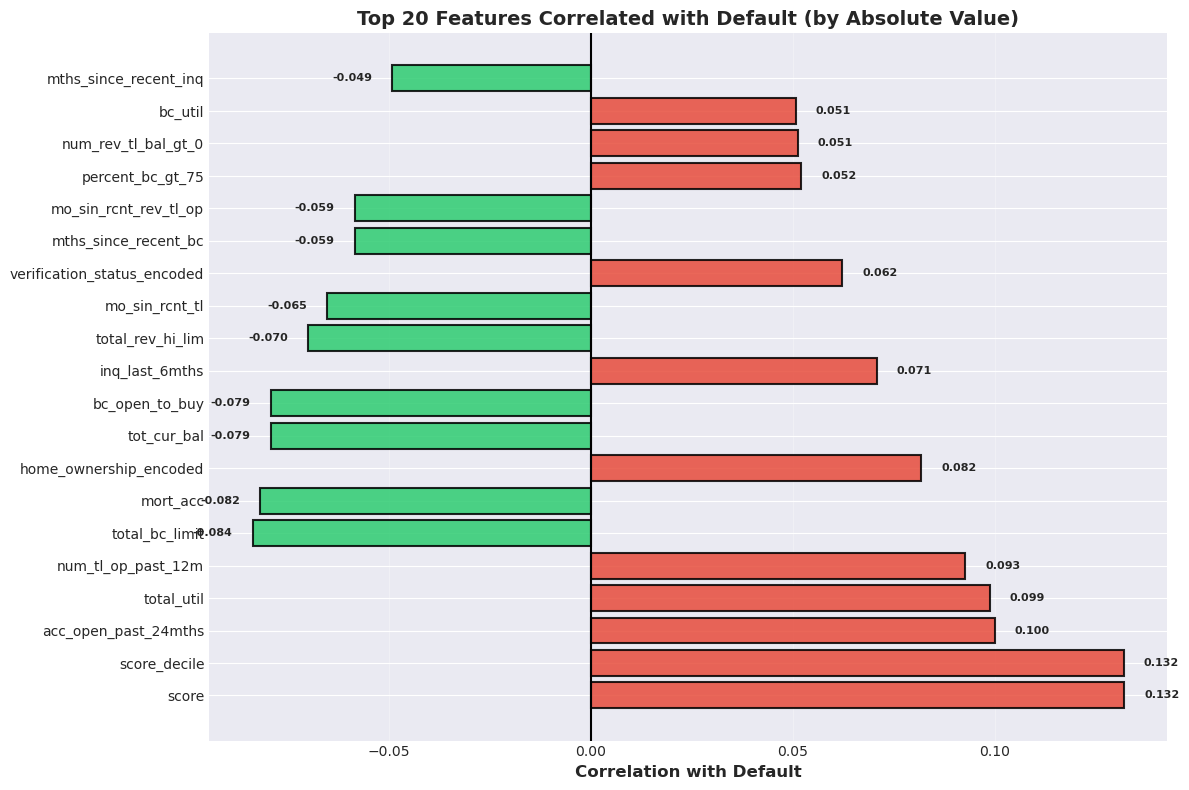

KEY INSIGHTS TO HIGHLIGHT IN YOUR PRESENTATION:
1. Overall default rate: 14.31%
2. Total loans analyzed: 44,543
3. Highest risk loan purposes: renewable_energy, moving, small_business
4. Highest risk home ownership: RENT
5. Median score - Defaulters: 0.2 vs Non-defaulters: 0.2
6. Top predictors (by correlation):
   1. score: 0.132
   2. score_decile: 0.132
   3. acc_open_past_24mths: 0.100
   4. total_util: 0.099
   5. num_tl_op_past_12m: 0.093


In [343]:
import matplotlib.pyplot as plt
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-darkgrid')  # If this doesn't work, remove this line

# ==================== GRAPH 1: Default Rate Overview ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1.1: Overall default rate
default_rate = df_loans['default'].mean()
axes[0, 0].bar(['Fully Paid', 'Charged Off'], 
               [1-default_rate, default_rate], 
               color=['#2ecc71', '#e74c3c'], 
               alpha=0.8, 
               edgecolor='black',
               linewidth=2)
axes[0, 0].set_ylabel('Proportion', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'Overall Default Rate: {default_rate:.2%}', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(alpha=0.3, axis='y')
for i, v in enumerate([1-default_rate, default_rate]):
    axes[0, 0].text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=12, fontweight='bold')

# 1.2: Default rate over time
time_default = df_loans.groupby(df_loans['issue_d'].dt.to_period('Q'))['default'].agg(['mean', 'count'])
time_default.index = time_default.index.to_timestamp()
axes[0, 1].plot(time_default.index, time_default['mean'] * 100, marker='o', linewidth=2.5, markersize=7, color='#e74c3c', markeredgecolor='black', markeredgewidth=1)
axes[0, 1].set_xlabel('Issue Date', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Default Rate (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Default Rate Trends Over Time', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 1.3: Default rate by loan purpose
purpose_default = df_loans.groupby('purpose')['default'].agg(['mean', 'count']).sort_values('mean', ascending=False)
top_purposes = purpose_default.head(10)
colors_purpose = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(top_purposes)))
bars = axes[1, 0].barh(range(len(top_purposes)), top_purposes['mean'] * 100, color=colors_purpose, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_yticks(range(len(top_purposes)))
axes[1, 0].set_yticklabels(top_purposes.index, fontsize=10)
axes[1, 0].set_xlabel('Default Rate (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Default Rate by Loan Purpose (Top 10)', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(top_purposes.iterrows()):
    axes[1, 0].text(row['mean'] * 100 + 0.5, i, f"{row['mean']:.1%}\n(n={row['count']})", va='center', fontsize=8)

# 1.4: Default rate by home ownership
home_default = df_loans.groupby('home_ownership')['default'].agg(['mean', 'count']).sort_values('mean', ascending=False)
colors_home = ['#e74c3c' if x > default_rate else '#2ecc71' for x in home_default['mean']]
bars = axes[1, 1].bar(range(len(home_default)), home_default['mean'] * 100, color=colors_home, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(len(home_default)))
axes[1, 1].set_xticklabels(home_default.index, rotation=45, ha='right', fontsize=10)
axes[1, 1].set_ylabel('Default Rate (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Default Rate by Home Ownership', fontsize=14, fontweight='bold')
axes[1, 1].axhline(y=default_rate * 100, color='black', linestyle='--', linewidth=2, label=f'Avg: {default_rate:.1%}')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, (idx, row) in enumerate(home_default.iterrows()):
    axes[1, 1].text(i, row['mean'] * 100 + 1, f"{row['mean']:.1%}\n(n={row['count']})", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# ==================== GRAPH 2: Key Numeric Features ====================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

key_vars = ['score', 'annual_inc', 'dti', 'revol_util', 'delinq_2yrs', 'credit_history_months']

for idx, var in enumerate(key_vars):
    row, col = idx // 3, idx % 3
    
    defaulters = df_loans[df_loans['default'] == 1][var].dropna()
    non_defaulters = df_loans[df_loans['default'] == 0][var].dropna()
    
    bp = axes[row, col].boxplot([non_defaulters, defaulters], 
                                  labels=['Fully Paid', 'Charged Off'],
                                  patch_artist=True,
                                  showfliers=False,
                                  widths=0.6)
    
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_alpha(0.7)
    bp['boxes'][0].set_edgecolor('black')
    bp['boxes'][1].set_edgecolor('black')
    bp['boxes'][0].set_linewidth(1.5)
    bp['boxes'][1].set_linewidth(1.5)
    
    for whisker in bp['whiskers']:
        whisker.set(linewidth=1.5)
    for cap in bp['caps']:
        cap.set(linewidth=1.5)
    for median in bp['medians']:
        median.set(color='darkblue', linewidth=2)
    
    axes[row, col].set_ylabel(var, fontsize=11, fontweight='bold')
    axes[row, col].set_title(f'{var} by Default Status', fontsize=12, fontweight='bold')
    axes[row, col].grid(axis='y', alpha=0.3)
    
    med_non_def = non_defaulters.median()
    med_def = defaulters.median()
    axes[row, col].text(0.5, 0.95, f'Median:\nPaid: {med_non_def:.0f}\nDefault: {med_def:.0f}', 
                        transform=axes[row, col].transAxes, fontsize=9, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# ==================== GRAPH 3: Binned Variables Impact ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

bin_cols_to_plot = ['income_bin', 'dti_bin', 'loan_amnt_bin', 'revol_util_bin']

for idx, col in enumerate(bin_cols_to_plot):
    row, col_idx = idx // 2, idx % 2
    
    bin_stats = df_loans.groupby(col)['default'].agg(['mean', 'count']).reset_index()
    bin_stats = bin_stats.sort_values('mean', ascending=False)
    
    colors_bin = plt.cm.plasma(np.linspace(0.2, 0.8, len(bin_stats)))
    bars = axes[row, col_idx].barh(range(len(bin_stats)), bin_stats['mean'] * 100, 
                                     color=colors_bin, alpha=0.85, edgecolor='black', linewidth=1.5)
    axes[row, col_idx].set_yticks(range(len(bin_stats)))
    axes[row, col_idx].set_yticklabels(bin_stats[col], fontsize=10)
    axes[row, col_idx].set_xlabel('Default Rate (%)', fontsize=12, fontweight='bold')
    axes[row, col_idx].set_title(f'Default Rate by {col}', fontsize=13, fontweight='bold')
    axes[row, col_idx].grid(axis='x', alpha=0.3)
    
    for i, (_, row_data) in enumerate(bin_stats.iterrows()):
        axes[row, col_idx].text(row_data['mean'] * 100 + 0.5, i, 
                                 f"{row_data['mean']:.1%} (n={int(row_data['count'])})", 
                                 va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# ==================== GRAPH 4: Correlation Heatmap (Manual) ====================
plt.figure(figsize=(14, 11))

corr_vars = ['default', 'score', 'annual_inc', 'dti', 'revol_util', 'delinq_2yrs', 
             'pub_rec', 'inq_last_6mths', 'open_acc', 'total_acc', 'credit_history_months',
             'num_actv_bc_tl', 'bc_util', 'tot_cur_bal', 'mo_sin_old_rev_tl_op']
corr_vars = [v for v in corr_vars if v in df_loans.columns]

corr_matrix = df_loans[corr_vars].corr()

im = plt.imshow(corr_matrix, cmap='RdYlGn_r', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im, shrink=0.8)

plt.xticks(range(len(corr_vars)), corr_vars, rotation=45, ha='right', fontsize=10)
plt.yticks(range(len(corr_vars)), corr_vars, fontsize=10)

for i in range(len(corr_vars)):
    for j in range(len(corr_vars)):
        text = plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=8)

plt.title('Correlation Matrix: Key Features vs Default', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ==================== GRAPH 5: Feature Importance Preview ====================
plt.figure(figsize=(12, 8))

numeric_features = [col for col in df_loans.select_dtypes(include=[np.number]).columns 
                    if col not in cols_ignore and col != 'default']
correlations = df_loans[numeric_features + ['default']].corr()['default'].drop('default').sort_values(key=abs, ascending=False)

top_corr = correlations.head(20)
colors_corr = ['#e74c3c' if x > 0 else '#2ecc71' for x in top_corr.values]

plt.barh(range(len(top_corr)), top_corr.values, color=colors_corr, alpha=0.85, edgecolor='black', linewidth=1.5)
plt.yticks(range(len(top_corr)), top_corr.index, fontsize=10)
plt.xlabel('Correlation with Default', fontsize=12, fontweight='bold')
plt.title('Top 20 Features Correlated with Default (by Absolute Value)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
plt.grid(axis='x', alpha=0.3)

for i, (idx, val) in enumerate(top_corr.items()):
    plt.text(val + 0.005 if val > 0 else val - 0.005, i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# ==================== Summary Statistics ====================
print("=" * 80)
print("KEY INSIGHTS TO HIGHLIGHT IN YOUR PRESENTATION:")
print("=" * 80)
print(f"1. Overall default rate: {default_rate:.2%}")
print(f"2. Total loans analyzed: {len(df_loans):,}")
print(f"3. Highest risk loan purposes: {', '.join(purpose_default.head(3).index.tolist())}")
print(f"4. Highest risk home ownership: {home_default.index[0]}")
print(f"5. Median score - Defaulters: {df_loans[df_loans['default']==1]['score'].median():.1f} vs Non-defaulters: {df_loans[df_loans['default']==0]['score'].median():.1f}")
print(f"6. Top predictors (by correlation):")
for i, (feat, corr_val) in enumerate(correlations.head(5).items(), 1):
    print(f"   {i}. {feat}: {corr_val:.3f}")
print("=" * 80)